# Predicting NBA players position

#### In this notebook I will use Machine Learning to predict the positions of NBA players.

PG: Point Guard<br>
SG: Shooting Guard<br>
SF: Small Forward<br>
PF: Power Forward<br>
C: Center<br>

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the datasets
players = pd.read_csv('nba-players-stats-since-1950/Players.csv', index_col = "Unnamed: 0")
df = pd.read_csv('nba-players-stats-since-1950/Seasons_Stats.csv', index_col = "Unnamed: 0")
stats = df[df['Year']>1990]

In [2]:
players.head()

,Player,height,weight,collage,born,birth_city,birth_state
0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky


In [3]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3922 entries, 0 to 3921
Data columns (total 7 columns):
Player         3921 non-null object
height         3921 non-null float64
weight         3921 non-null float64
collage        3573 non-null object
born           3921 non-null float64
birth_city     3452 non-null object
birth_state    3439 non-null object
dtypes: float64(3), object(4)
memory usage: 245.1+ KB


#### Let's check if two different players share the same name:

In [4]:
np.where(players['Player'].value_counts()>1)

(array([], dtype=int64),)

In [5]:
stats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
10007,1991.0,Alaa Abdelnaby,PF,22.0,POR,43.0,0.0,290.0,13.1,0.499,...,0.568,27.0,62.0,89.0,12.0,4.0,12.0,22.0,39.0,135.0
10008,1991.0,Mahmoud Abdul-Rauf,PG,21.0,DEN,67.0,19.0,1505.0,12.2,0.448,...,0.857,34.0,87.0,121.0,206.0,55.0,4.0,110.0,149.0,942.0
10009,1991.0,Mark Acres,C,28.0,ORL,68.0,0.0,1313.0,9.2,0.551,...,0.653,140.0,219.0,359.0,25.0,25.0,25.0,42.0,218.0,285.0
10010,1991.0,Michael Adams,PG,28.0,DEN,66.0,66.0,2346.0,22.3,0.530,...,0.879,58.0,198.0,256.0,693.0,147.0,6.0,240.0,162.0,1752.0
10011,1991.0,Mark Aguirre,SF,31.0,DET,78.0,13.0,2006.0,16.7,0.526,...,0.757,134.0,240.0,374.0,139.0,47.0,20.0,128.0,209.0,1104.0


In [6]:
stats = stats.reset_index(drop=True)

In [7]:
stats.shape

(14658, 52)

In [8]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14658 entries, 0 to 14657
Data columns (total 52 columns):
Year      14658 non-null float64
Player    14658 non-null object
Pos       14658 non-null object
Age       14658 non-null float64
Tm        14658 non-null object
G         14658 non-null float64
GS        14658 non-null float64
MP        14658 non-null float64
PER       14653 non-null float64
TS%       14588 non-null float64
3PAr      14581 non-null float64
FTr       14581 non-null float64
ORB%      14653 non-null float64
DRB%      14653 non-null float64
TRB%      14653 non-null float64
AST%      14653 non-null float64
STL%      14653 non-null float64
BLK%      14653 non-null float64
TOV%      14601 non-null float64
USG%      14653 non-null float64
blanl     0 non-null float64
OWS       14658 non-null float64
DWS       14658 non-null float64
WS        14658 non-null float64
WS/48     14653 non-null float64
blank2    0 non-null float64
OBPM      14658 non-null float64
DBPM      1

In [9]:
stats['Year'] = stats['Year'].astype(int);

#### I will drop the players who played during a very short time per game (less than 5 min) as their stats might not be sufficient to predict their position.

In [10]:
stats = stats[stats.MP/stats.G > 5]

In [11]:
stats.shape

(13744, 52)

#### It is irrelevant to keep TOV%, FG%, 3P%, 2P%, eFG%, FT% and PTS as they are calculated using other data from the same player.
#### The number of games started (GS) won't help to predict the position of the player as one player of each position usually begin the game. Neither will the number of games played (G).
#### I will also get rid of the 'blanl' and the 'blank2' columns that are empty, and of the Tm column.

In [12]:
col_to_clean = ['TOV%', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'blanl', 'blank2', 'Tm', 'PTS', 'GS', 'G']
stats_clean = stats.drop(col_to_clean, axis=1)

In [13]:
stats_clean.head()

,Year,Player,Pos,Age,MP,PER,TS%,3PAr,FTr,ORB%,...,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF
0,1991,Alaa Abdelnaby,PF,22.0,290.0,13.1,0.499,0.000,0.379,10.4,...,25.0,44.0,27.0,62.0,89.0,12.0,4.0,12.0,22.0,39.0
1,1991,Mahmoud Abdul-Rauf,PG,21.0,1505.0,12.2,0.448,0.099,0.097,1.9,...,84.0,98.0,34.0,87.0,121.0,206.0,55.0,4.0,110.0,149.0
2,1991,Mark Acres,C,28.0,1313.0,9.2,0.551,0.014,0.472,11.3,...,66.0,101.0,140.0,219.0,359.0,25.0,25.0,25.0,42.0,218.0
3,1991,Michael Adams,PG,28.0,2346.0,22.3,0.530,0.397,0.372,2.1,...,465.0,529.0,58.0,198.0,256.0,693.0,147.0,6.0,240.0,162.0
4,1991,Mark Aguirre,SF,31.0,2006.0,16.7,0.526,0.086,0.349,7.6,...,240.0,317.0,134.0,240.0,374.0,139.0,47.0,20.0,128.0,209.0


#### The only relevant information in the players dataset is the height and the weight. The date of birth is interesting as well (as power forward and centre tend to play older) but the age on the 1 February of the given season is already in the stats dataset.
#### Because the players have unique names (checked at the beginning), we can merge the two dataframes using the 'Player' column.

In [14]:
df_merged = pd.merge(players[['Player', 'height', 'weight']], stats_clean, how='inner', on='Player',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)

In [15]:
df_merged.head()

,Player,height,weight,Year,Pos,Age,MP,PER,TS%,3PAr,...,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF
0,A.C. Green,203.0,106.0,1991,PF,27.0,2164.0,13.8,0.556,0.101,...,223.0,302.0,201.0,315.0,516.0,71.0,59.0,23.0,99.0,117.0
1,A.C. Green,203.0,106.0,1992,PF,28.0,2902.0,16.7,0.556,0.070,...,340.0,457.0,306.0,456.0,762.0,117.0,91.0,36.0,111.0,141.0
2,A.C. Green,203.0,106.0,1993,PF,29.0,2819.0,16.3,0.603,0.065,...,277.0,375.0,287.0,424.0,711.0,116.0,88.0,39.0,116.0,149.0
3,A.C. Green,203.0,106.0,1994,PF,30.0,2825.0,17.0,0.555,0.038,...,266.0,362.0,275.0,478.0,753.0,137.0,70.0,38.0,100.0,142.0
4,A.C. Green,203.0,106.0,1995,SF,31.0,2687.0,14.2,0.596,0.206,...,251.0,343.0,194.0,475.0,669.0,127.0,55.0,31.0,114.0,146.0


#### I will move the 'PS' column at the end and use it as a label and put the 'Year' column at the beginning as I won't use it to predict the position.

In [16]:
cols = df_merged.columns.tolist()
cols = cols[0:1] + cols[3:4] + cols[1:3] + cols[5:] + cols[4:5]
df = df_merged[cols]

#### I replace the NaN values with 0.

In [17]:
df = df.fillna(0)

#### Let's have a look at the labels:

In [18]:
df.Pos.value_counts()

PF       2845
PG       2827
SG       2677
C        2663
SF       2560
PG-SG      27
C-PF       23
SG-SF      22
SF-SG      21
PF-C       20
SG-PG      20
PF-SF      17
SF-PF      17
SG-PF       3
PG-SF       1
C-SF        1
Name: Pos, dtype: int64

#### Let's keep only the 5 'single' positions as there is not enough data for the players who can have two different positions.

In [19]:
df = df[df.Pos.isin(['PF', 'PG', 'C', 'SG', 'SF'])]

## Classification using scikit-learn:

In [20]:
# Selecting Data and Target
X = df.iloc[:, 2:-1]
y = df.iloc[:, -1]

In [21]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [22]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### I'll try different models and see which one perform the best.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [24]:
classifiers = {
    'K-Nearest Neighbours' : KNeighborsClassifier(3),
    'Kernel SVM': SVC(kernel = 'rbf', random_state = 42),
    'Desicion Tree' : DecisionTreeClassifier(max_depth=5, criterion = 'entropy', random_state = 42),
    'Random Forest' : RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, 
                                             criterion = 'entropy', random_state = 42)}

In [25]:
from sklearn.model_selection import cross_val_score

for c in classifiers:
    classifier = classifiers[c]
    
    cv_results = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy')
    print('CV Scoring for {}: '.format(c), cv_results)
    print('Mean of CV Scores for {}: '.format(c), np.mean(cv_results), '\n')

CV Scoring for Random Forest:  [ 0.56624606  0.57991588  0.55608215  0.57345972  0.55426765]
Mean of CV Scores for Random Forest:  0.565994289821 

CV Scoring for Desicion Tree:  [ 0.67245005  0.68822292  0.68351764  0.70774092  0.67386723]
Mean of CV Scores for Desicion Tree:  0.685159752322 

CV Scoring for K-Nearest Neighbours:  [ 0.64931651  0.64721346  0.64454976  0.65455503  0.66069547]
Mean of CV Scores for K-Nearest Neighbours:  0.651266045873 

CV Scoring for Kernel SVM:  [ 0.73133544  0.73238696  0.7235387   0.75092154  0.73498419]
Mean of CV Scores for Kernel SVM:  0.734633366719 



#### Kernel SVM has the best result. I'll use this algorithm to make predictions on the test set after I've tuned this model.

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' :[0.001, 0.01, 0.1, 1]}

grid_search_kernelSVM = GridSearchCV(SVC(kernel='rbf', random_state = 42), param_grid, cv=5)

grid_search_kernelSVM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': [0.001, 0.01, 0.1, 1], 'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [27]:
grid_search_kernelSVM.best_params_

{'C': 10, 'gamma': 0.01}

In [28]:
classifier = grid_search_kernelSVM.best_estimator_
    
# Fitting the clasifier to the Training set
classifier.fit(X_train, y_train)
    
# Predicting the Test set results
y_pred = classifier.predict(X_test)
    
# Scores for Training and Test sets
print('Scoring on Training Data for Kernel SVM: ', classifier.score(X_train, y_train))
print('Scoring on Testing Data for Kernel SVM: ', classifier.score(X_test, y_test))

Scoring on Training Data for Kernel SVM:  0.792842105263
Scoring on Testing Data for Kernel SVM:  0.740913555992


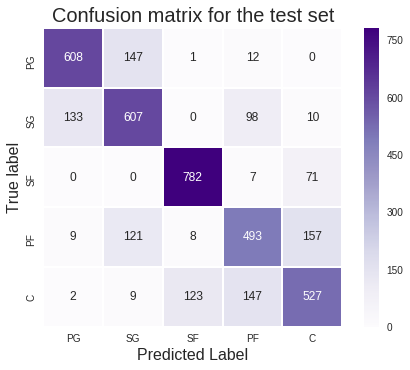

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
def plot_cm(matrix, labels):
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        sns.heatmap(matrix, annot = True, fmt='d', xticklabels = labels, yticklabels = labels,
                    square = True, linewidths=1, cmap = 'Purples')
        plt.xlabel('Predicted Label', fontsize=16)
        plt.ylabel('True label', fontsize=16)
        plt.title('Confusion matrix for the test set', fontsize=20)
        plt.show()
        
plot_cm(cm, ['PG', 'SG', 'SF', 'PF', 'C'])

### These are good predictions as some players can be labelled with two different positions.
### On top of that, the mistakes made by the model are not huge mistakes. For example, we can see that centers have sometimes been predicted as Small Forward (maybe because they are usually both good in defence) but never as Point Guard.